Dataset Shape: (119390, 33)
   id         hotel  is_canceled  lead_time  arrival_date_year  \
0   1  Resort Hotel          0.0      342.0               2015   
1   2  Resort Hotel          0.0      737.0               2015   
2   3  Resort Hotel          0.0        7.0               2015   
3   4  Resort Hotel          0.0       13.0               2015   
4   5  Resort Hotel          0.0       14.0               2015   

  arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0               July                      27.0                        1.0   
1               July                      27.0                        1.0   
2               July                      27.0                        1.0   
3               July                      27.0                        1.0   
4               July                      27.0                        1.0   

   stays_in_weekend_nights  stays_in_week_nights  ...  deposit_type  agent  \
0                      0.0        

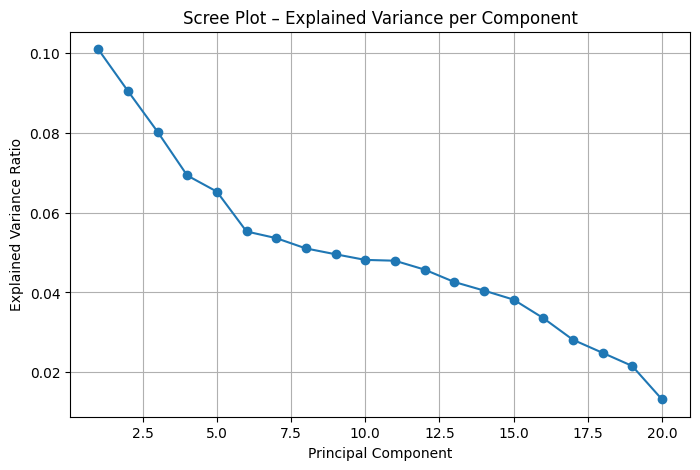

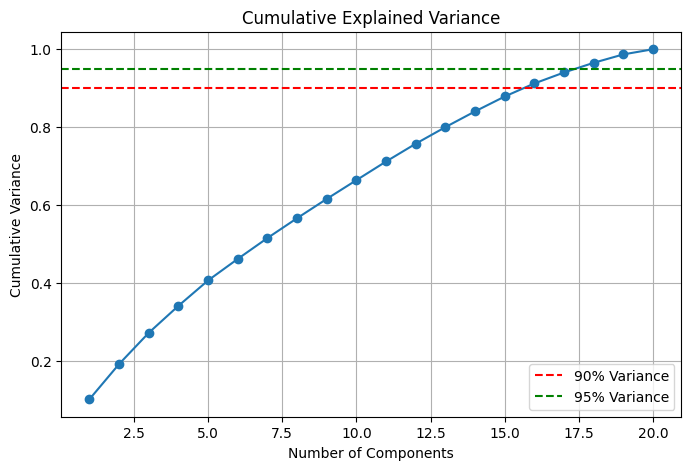


Components needed for 95% variance: 18
Original Shape: (119380, 20)
Reduced Shape: (119380, 18)

Top Loadings for PC1:
stays_in_week_nights              0.473104
stays_in_weekend_nights           0.434351
agent                             0.383434
id                                0.369934
is_repeated_guest                 0.286833
previous_bookings_not_canceled    0.250733
adults                            0.217335
lead_time                         0.167250
adr                               0.141515
children                          0.120005
Name: PC1, dtype: float64


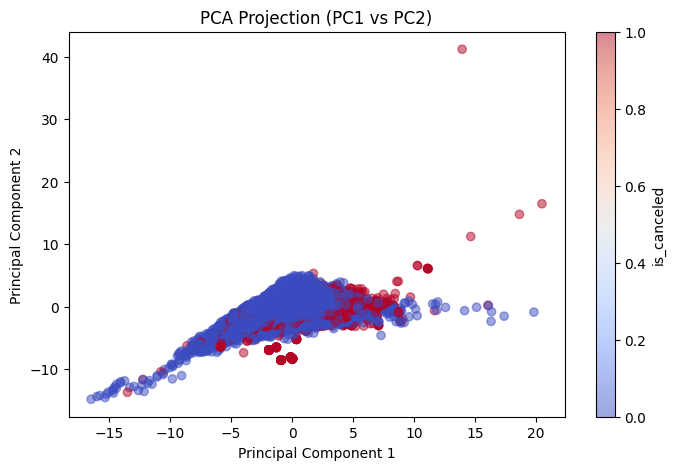


Reconstruction Error: 0.03481595201517177

===== MODEL COMPARISON =====
Without PCA → Accuracy: 0.8179, Training Time: 0.2835s
With PCA    → Accuracy: 0.7318, Training Time: 0.1589s

===== PCA SUMMARY =====
Original Features      : 20
Reduced Features       : 18
Variance Retained      : 96.52%
Accuracy Change        : -0.0861
Training Speed Gain    : 0.1245s


In [5]:
# =====================================================
# WEEK 9: PCA – COMPLETE DEMONSTRATION
# Dataset: Hotel Booking Cancellation
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# -----------------------------------------------------
# 1. Load Dataset
# -----------------------------------------------------
url = "https://raw.githubusercontent.com/swapnilsaurav/Dataset/refs/heads/master/hotel_bookings.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
print(df.head())

# -----------------------------------------------------
# 2. Select Numeric Features Only
# (PCA works only on numeric, scaled data)
# -----------------------------------------------------
numeric_df = df.select_dtypes(include=['int64', 'float64']).copy()

# Drop target if present
target = 'is_canceled'

#contains missing values ?
numeric_df[target].isna().sum()
# you cannot train a supervised model without a valid label.
numeric_df = numeric_df.dropna(subset=[target])

X = numeric_df.drop(columns=[target])
y = numeric_df[target]

print("\nNumeric Feature Count:", X.shape[1])

# -----------------------------------------------------
# 3. Handle Missing Values (Simple Strategy)
# -----------------------------------------------------
X = X.fillna(X.median())

# -----------------------------------------------------
# 4. Standardization (MANDATORY for PCA)
# -----------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------------------------------
# 5. PCA WITHOUT Dimensionality Reduction
# (to extract explained variance & scree plot)
# -----------------------------------------------------
pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# -----------------------------------------------------
# 6. Scree Plot (Elbow Method)
# -----------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Scree Plot – Explained Variance per Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# -----------------------------------------------------
# 7. Cumulative Explained Variance Plot
# -----------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.axhline(y=0.95, color='g', linestyle='--', label="95% Variance")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------
# 8. Choose Number of Components (95% variance)
# -----------------------------------------------------
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print("\nComponents needed for 95% variance:", n_components_95)

# -----------------------------------------------------
# 9. Apply PCA with Selected Components
# -----------------------------------------------------
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

print("Original Shape:", X_scaled.shape)
print("Reduced Shape:", X_pca.shape)

# -----------------------------------------------------
# 10. PCA Component Loadings (Interpretation)
# -----------------------------------------------------
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components_95)],
    index=X.columns
)

print("\nTop Loadings for PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head(10))

# -----------------------------------------------------
# 11. 2D Visualization (PC1 vs PC2)
# -----------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (PC1 vs PC2)")
plt.colorbar(label="is_canceled")
plt.show()

# -----------------------------------------------------
# 12. Inverse Transform (Information Loss Demo)
# -----------------------------------------------------
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)
print("\nReconstruction Error:", reconstruction_error)

# -----------------------------------------------------
# 13. Model WITHOUT PCA
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

start = time.time()
model_original = LogisticRegression(max_iter=1000)
model_original.fit(X_train, y_train)
time_original = time.time() - start

acc_original = accuracy_score(y_test, model_original.predict(X_test))

# -----------------------------------------------------
# 14. Model WITH PCA
# -----------------------------------------------------
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)

start = time.time()
model_pca = LogisticRegression(max_iter=1000)
model_pca.fit(X_train_pca, y_train)
time_pca = time.time() - start

acc_pca = accuracy_score(y_test, model_pca.predict(X_test_pca))

# -----------------------------------------------------
# 15. Performance Comparison
# -----------------------------------------------------
print("\n===== MODEL COMPARISON =====")
print(f"Without PCA → Accuracy: {acc_original:.4f}, Training Time: {time_original:.4f}s")
print(f"With PCA    → Accuracy: {acc_pca:.4f}, Training Time: {time_pca:.4f}s")

# -----------------------------------------------------
# 16. Final Summary (Teaching Output)
# -----------------------------------------------------
print("\n===== PCA SUMMARY =====")
print(f"Original Features      : {X.shape[1]}")
print(f"Reduced Features       : {n_components_95}")
print(f"Variance Retained      : {cumulative_variance[n_components_95-1]:.2%}")
print(f"Accuracy Change        : {acc_pca - acc_original:.4f}")
print(f"Training Speed Gain    : {(time_original - time_pca):.4f}s")
